In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from datetime import datetime
from scipy import stats
from plotly.subplots import make_subplots
from cryptocmd import CmcScraper
from arch import arch_model
import yfinance as yf
import talib as talib

sns.set_style("darkgrid")
style.use("seaborn-talk")

In [2]:
coinname='LEO'

In [3]:
def get_crypto_data(coin_name):
    scraper = CmcScraper(coin_name)
    coin_df = scraper.get_dataframe()
    coin_df = pd.DataFrame(coin_df, columns=['Date','Close'])
    coin_df.set_index('Date', inplace=True)
    coin_df = coin_df.rename(columns = {'Close':coin_name})
    coin_df = coin_df.iloc[::-1]
    return coin_df
def get_stock_data(stock_name):
    data = yf.Ticker(stock_name).history(period='10y')
    data = pd.DataFrame(data, columns=['Close'])
    data = data.rename(columns = {'Close':stock_name})    
    return data

In [4]:
coin_df = get_crypto_data(coinname)

In [5]:
coin_df['EMA20'] = talib.EMA(coin_df[coinname], timeperiod=20)

In [6]:
coin_df['returns'] = np.log(coin_df[coinname]).diff().mul(100).dropna()
coin_df.dropna(inplace=True)

In [7]:
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum((series_log_return)**2)/(n - 1))

def get_volatility(coin_df, t_window):
    vols = coin_df['returns'].rolling(window=t_window).apply(realized_volatility_daily).values
    coin_df['volatility'] = vols
        
    return coin_df

In [8]:
coin_df = get_volatility(coin_df, 7)

In [9]:
gjrgarch_gm = arch_model(coin_df.returns, p=1, q=1, o=1, mean='constant', vol='GARCH', dist='skewt') 
gjrgarch_result = gjrgarch_gm.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 26650.27909669424
Iteration:      2,   Func. Count:     20,   Neg. LLF: 31115.944216768672
Iteration:      3,   Func. Count:     30,   Neg. LLF: 30616.487554795607
Iteration:      4,   Func. Count:     39,   Neg. LLF: 40597.436955719444
Iteration:      5,   Func. Count:     48,   Neg. LLF: 3721.2349079683922
Iteration:      6,   Func. Count:     57,   Neg. LLF: 3019.1918029736707
Iteration:      7,   Func. Count:     66,   Neg. LLF: 2639.4284740756534
Iteration:      8,   Func. Count:     75,   Neg. LLF: 2231.3692749962547
Iteration:      9,   Func. Count:     84,   Neg. LLF: 2202.4374467882863
Iteration:     10,   Func. Count:     93,   Neg. LLF: 2398.870543980858
Iteration:     11,   Func. Count:    102,   Neg. LLF: 2198.275213493975
Iteration:     12,   Func. Count:    111,   Neg. LLF: 2193.64861733827
Iteration:     13,   Func. Count:    119,   Neg. LLF: 2192.7788506288307
Iteration:     14,   Func. Count:    127,   Neg. LLF: 21

In [10]:
gjrgarch_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - GJR-GARCH Model Results                         
=========================================================================================
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -2192.48
Distribution:      Standardized Skew Student's t   AIC:                           4398.95
Method:                       Maximum Likelihood   BIC:                           4433.58
                                                   No. Observations:                 1040
Date:                           Thu, Apr 14 2022   Df Residuals:                     1039
Time:                                   10:32:19   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu         7.5052e-03  4.748e-02      0.158      0.874 [-8.556e-02,  0.101]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0466  8.099e-02      0.575      0.565    [ -0.112,  0.205]
alpha[1]       0.0881  4.975e-02      1.771  7.649e-02 [-9.379e-03,  0.186]
gamma[1]       0.1044  3.880e-02      2.691  7.114e-03  [2.838e-02,  0.180]
beta[1]        0.8597  7.054e-02     12.186  3.686e-34    [  0.721,  0.998]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
eta            3.0690      0.215     14.292  2.463e-46      [  2.648,  3.490]
lambda        -0.0262  3.276e-02     -0.798      0.425 [-9.037e-02,3.806e-02]
=============================================================================

Covariance estimator: robust
"""

In [11]:
coin_df['garch'] = gjrgarch_result.conditional_volatility

In [12]:
alpha = 0.01
def get_VaR(garch_result, start_date, days):
    target_forecast = garch_result.forecast(start=start_date)

    mean_forecast = target_forecast.mean[start_date:]
    variance_forecast = target_forecast.variance[start_date:]

    q_empirical = garch_result.std_resid.quantile(alpha)
    #print(f'{alpha*100}% empirical quantile: ', q_empirical)

    VaR_empirical = mean_forecast.values + np.sqrt(variance_forecast).values * q_empirical * np.sqrt(days)
    VaR_empirical = pd.DataFrame(VaR_empirical, columns = [f'{alpha*100}%'], index = variance_forecast.index)
    return VaR_empirical

In [13]:
start_date = coin_df.index[0]
coin_df['VaR'] = get_VaR(gjrgarch_result, start_date, 1)

In [14]:
def plot_all(coin_df):
    #plt.style.use('classic')    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,14))
    axes[0,0].plot(coin_df[coinname], color='lightcoral', label='Close Price')
    axes[0,0].plot(coin_df['EMA20'], color='grey', label='EMA20')
    axes[0,0].set(title=coinname+' Price', xlabel='date', ylabel='Price ($)')
    axes[0,0].legend(loc='best')    
    sns.distplot(coin_df.returns, norm_hist=True, fit=stats.t, color='lightcoral', bins=100, ax=axes[0,1])
    axes[0,1].set_title('Returns distribution') 
    axes[1,0].plot(coin_df.volatility, color='red', label='7 days rolling volatility')
    axes[1,0].plot(coin_df.garch, color='blue', label='GJR-GARCH(1,1)')    
    axes[1,0].legend(loc='best')
    axes[1,0].set(title='Volatility', xlabel='date', ylabel='Volatility (%)')    
    axes[1,1].plot(coin_df.VaR[-365*2:], color = 'red', lw=3, label = f'{alpha*100}% VaR', alpha=1)
    axes[1,1].scatter(coin_df.index[-365*2:], coin_df.returns[-365*2:], color='grey', label = coinname+' returns')
    axes[1,1].legend(loc='best')
    fig.savefig(f'images/{coinname}.png')

In [15]:
days = [1, 3, 7, 10]
var = {}
print(f'Pledge Ratio for {coinname}:\n')
for i in range(len(days)):
    var[i] = 100+get_VaR(gjrgarch_result, start_date, days[i]).mean().values[0]
    var[i] = "{:.2f}".format(var[i])
    print(f'{days[i]} days\t: {var[i]}%')

Pledge Ratio for LEO:

1 days	: 91.10%
3 days	: 84.58%
7 days	: 76.43%
10 days	: 71.83%


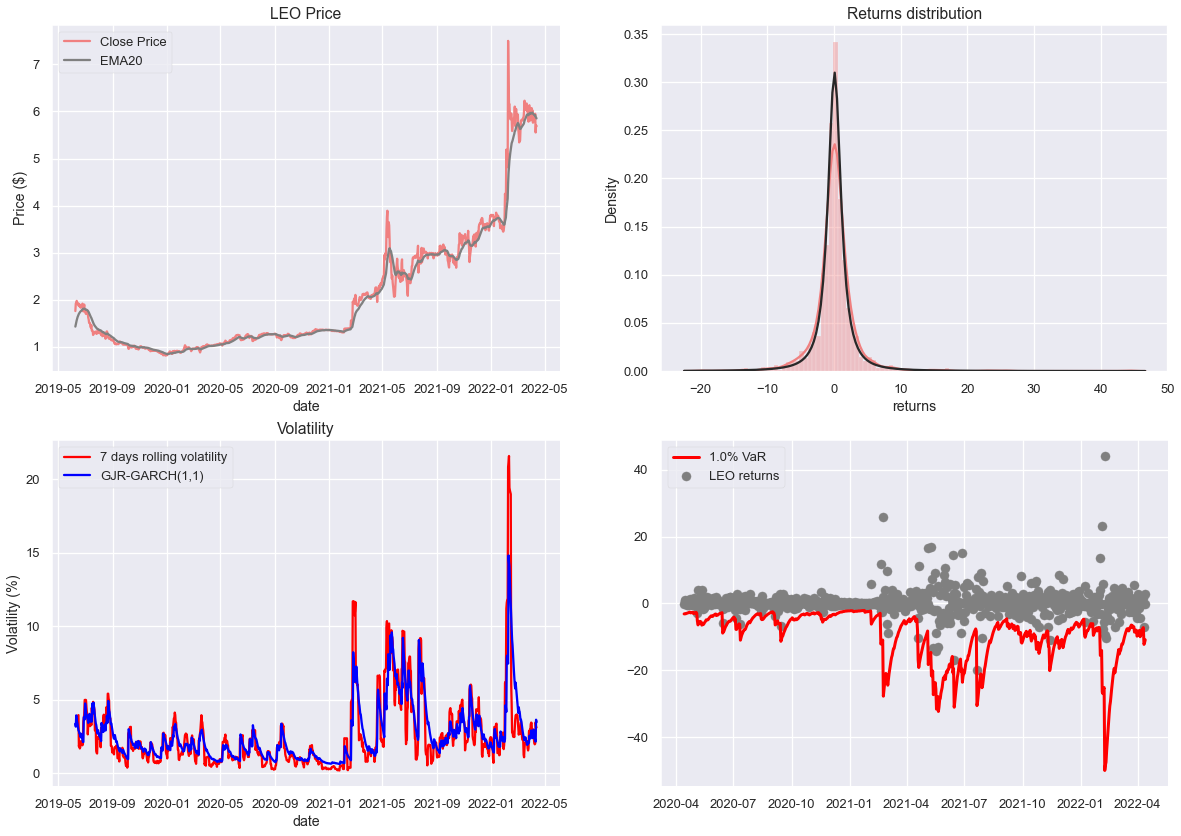

In [16]:
plot_all(coin_df)